## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir("drive/My Drive/BTP/NN")

In [3]:
!ls

Model1.ipynb  Model3.ipynb  Neuralnetwork.ipynb  SlidingWindows.py
Model2.ipynb  Network.py    __pycache__


## Import Modules and Data

In [4]:
import numpy as np
import pandas as pd
import copy as cp
import pandas as pd
import matplotlib.pyplot as plt
from SlidingWindows import *
from Network import *
import time
import seaborn as sns
sns.set()

In [5]:
data = pd.read_csv('../data/sales_train_validation.csv')
calender = pd.read_csv('../data/calendar.csv')
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


## Analysis for a category in one particular state

In [6]:
cat_id = "HOUSEHOLD"

state_id_1 = "CA"
category_state = data[(data['cat_id'] == cat_id) & (data['state_id'] == state_id_1)].to_numpy()[:,6:]
category_state.shape
y1 = np.sum(category_state, axis = 0)
print(y1.shape)

state_id_2 = "TX"
category_state = data[(data['cat_id'] == cat_id) & (data['state_id'] == state_id_2)].to_numpy()[:,6:]
category_state.shape
y2 = np.sum(category_state, axis = 0)
print(y2.shape)

state_id_3 = "WI"
category_state = data[(data['cat_id'] == cat_id) & (data['state_id'] == state_id_3)].to_numpy()[:,6:]
category_state.shape
y3 = np.sum(category_state, axis = 0)
print(y3.shape)

(1913,)
(1913,)
(1913,)


In [7]:
def divide(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

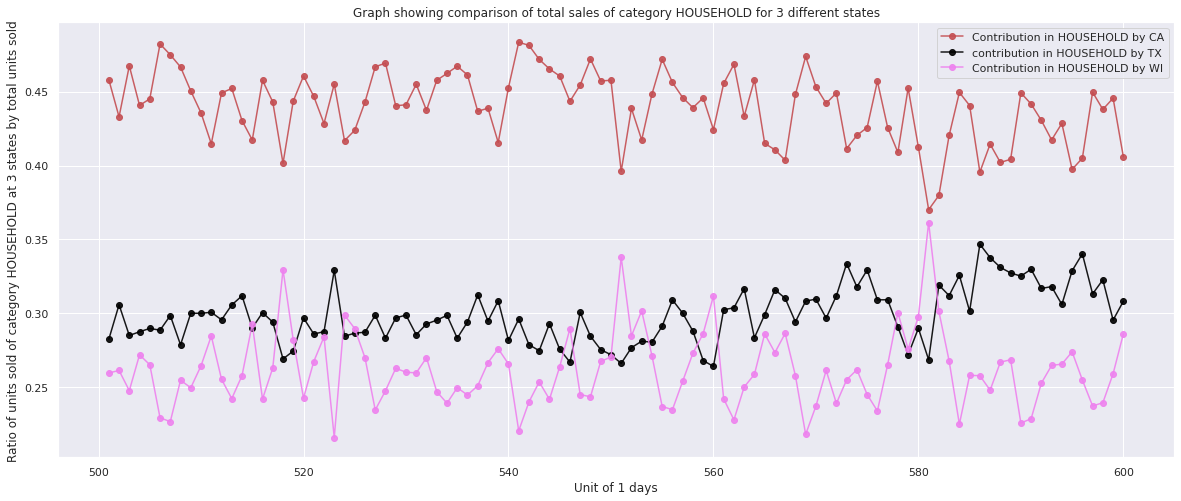

In [8]:
start = 400
end = 1913
MAX = 1913

# distribution_CA = 
# distribution_WI = divide(y1, (y1 + y2 + y3))[start:end]
# distribution_TX = 

mean_y1 = divide(y1, (y1 + y2 + y3))[start:end].mean()
distribution_CA = [i if i > 0 and i < 1 else mean_y1 for i in divide(y1, (y1 + y2 + y3))[start:end]]

mean_y2 = divide(y2, (y1 + y2 + y3))[start:end].mean()
distribution_TX = [i if i > 0 and i < 1 else mean_y2 for i in divide(y2, (y1 + y2 + y3))[start:end]] 

mean_y3 = divide(y3, (y1 + y2 + y3))[start:end].mean()
distribution_WI = [i if i > 0 and i < 1 else mean_y3 for i in divide(y3, (y1 + y2 + y3))[start:end]] 

t = np.array(range(1, MAX + 1))[start:end]

plt.figure(figsize=(20, 8))

graph_start = 100
graph_end = 200

plt.plot(t[graph_start: graph_end], distribution_CA[graph_start: graph_end],label=f'Contribution in {cat_id} by {state_id_1}',marker='o', c="r", alpha=0.9)
plt.plot(t[graph_start: graph_end], distribution_TX[graph_start: graph_end],label=f'contribution in {cat_id} by {state_id_2}',marker='o', c="black", alpha=0.9)
plt.plot(t[graph_start: graph_end], distribution_WI[graph_start: graph_end],label=f'Contribution in {cat_id} by {state_id_3}',marker='o', c="violet", alpha=0.9)

plt.xlabel(f'Unit of 1 days')
plt.ylabel(f'Ratio of units sold of category {cat_id} at 3 states by total units sold')
plt.legend() 
plt.title(f'Graph showing comparison of total sales of category {cat_id} for 3 different states')
plt.show()

## Add events to training set

In [9]:
# calender

In [10]:
# calender.event_type_1.dropna().unique()

In [11]:
for evnt in calender.event_type_1.dropna().unique():
  calender[f'{evnt.lower()}_1'] = [1 if type(i) == str and i == evnt else 0 for i in calender.event_type_1]

for evnt in calender.event_type_1.dropna().unique():
  calender[f'{evnt.lower()}_2'] = [1 if type(i) == str and i == evnt else 0 for i in calender.event_type_2]

calender_train_data = calender.iloc[:,11:][start:end].reset_index(drop=True)
# calender_train_data

In [12]:
shift = 7 * 52
sz = end - start
period = 7
# t = np.arange(start, end, 1).reshape(-1,1)

previous_days_y = np.array([t])
columns = ['t']

for s in range(7, shift + 1, period):
  columns.append('x1' + str(s//period))
  x1 = np.array([distribution_CA[i-s] if i - s >= 0 else 0 for i in range(0,sz)])
  previous_days_y = np.vstack([previous_days_y, x1])

for s in range(7, shift + 1, period):
  columns.append('x2' + str(s//period))
  x1 = np.array([distribution_TX[i-s] if i - s >= 0 else 0 for i in range(0,sz)])
  previous_days_y = np.vstack([previous_days_y, x1])

for s in range(7, shift + 1, period):
  columns.append('x3' + str(s//period))
  x1 = np.array([distribution_WI[i-s] if i - s >= 0 else 0 for i in range(0,sz)])
  previous_days_y = np.vstack([previous_days_y, x1])

previous_days_y.shape

(157, 1513)

## Build dataset

In [13]:
concatenated_data_tuple = tuple(previous_days_y)

dataset = pd.DataFrame(np.transpose(previous_days_y), columns = columns)

dataset = pd.concat([dataset, calender_train_data], axis=1)

dataset = dataset.iloc[shift:,:].reset_index(drop=True)

dataset['y1'] = distribution_CA[shift:]
dataset['y2'] = distribution_TX[shift:]
dataset['y3'] = distribution_WI[shift:]


In [14]:
dataset

,t,x11,x12,x13,x14,x15,x16,x17,x18,x19,x110,x111,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136,x137,x138,x139,...,x327,x328,x329,x330,x331,x332,x333,x334,x335,x336,x337,x338,x339,x340,x341,x342,x343,x344,x345,x346,x347,x348,x349,x350,x351,x352,snap_CA,snap_TX,snap_WI,sporting_1,cultural_1,national_1,religious_1,sporting_2,cultural_2,national_2,religious_2,y1,y2,y3
0,765.0,0.414589,0.383434,0.373283,0.382203,0.455748,0.412397,0.461803,0.427554,0.425485,0.439244,0.449363,0.427520,0.411186,0.439151,0.465781,0.423485,0.447821,0.448183,0.491786,0.465233,0.465368,0.428542,0.426384,0.449632,0.449182,0.420344,0.457071,0.473792,0.468510,0.471850,0.472094,0.483477,0.462342,0.466830,0.460589,0.452155,0.482252,0.456248,0.480069,...,0.233860,0.217986,0.227841,0.236857,0.243441,0.220426,0.239090,0.234521,0.242582,0.242221,0.229229,0.234820,0.220904,0.215000,0.204681,0.210742,0.215635,0.219766,0.218203,0.220142,0.177903,0.221939,0.217787,0.228470,0.217347,0.254643,1,1,1,0,0,0,0,0,0,0,0,0.425116,0.295793,0.279091
1,766.0,0.414346,0.422757,0.416992,0.421729,0.405203,0.452441,0.436290,0.404371,0.349215,0.459607,0.416810,0.443704,0.403851,0.423695,0.443833,0.444241,0.428633,0.428818,0.459850,0.406660,0.488400,0.406081,0.428871,0.437963,0.441633,0.449469,0.425720,0.453294,0.433281,0.456212,0.457205,0.481302,0.467238,0.469308,0.446769,0.430405,0.474939,0.431806,0.417340,...,0.265153,0.237142,0.250065,0.234751,0.267409,0.240006,0.249624,0.247552,0.267293,0.257792,0.226626,0.251944,0.248581,0.204797,0.238983,0.227883,0.242061,0.238247,0.224096,0.249806,0.247661,0.239180,0.220235,0.239972,0.230592,0.245187,1,0,0,0,0,0,0,0,0,0,0,0.406968,0.312606,0.280426
2,767.0,0.406386,0.373881,0.376745,0.378021,0.423047,0.434557,0.418239,0.424533,0.391686,0.441593,0.438688,0.428547,0.423065,0.436519,0.428890,0.420639,0.428525,0.428240,0.452790,0.421966,0.439888,0.404067,0.409374,0.445582,0.430515,0.440616,0.408843,0.442042,0.457962,0.445961,0.457720,0.471823,0.461294,0.440405,0.428418,0.417302,0.466696,0.458114,0.450351,...,0.300384,0.261272,0.258630,0.253993,0.270381,0.253512,0.244638,0.262725,0.284045,0.292647,0.254668,0.259541,0.242263,0.253127,0.239161,0.225690,0.235922,0.273401,0.218202,0.235233,0.251287,0.236419,0.253271,0.244567,0.254539,0.280427,1,1,1,0,0,0,0,0,0,0,0,0.427400,0.351154,0.221446
3,768.0,0.409071,0.387016,0.344666,0.369908,0.433109,0.428870,0.417891,0.411875,0.403599,0.426755,0.386009,0.411132,0.384123,0.415847,0.376719,0.400245,0.425326,0.373372,0.452562,0.429876,0.412814,0.399296,0.405652,0.405911,0.417322,0.395543,0.452401,0.449137,0.414972,0.439134,0.396082,0.465369,0.436668,0.441129,0.455076,0.457664,0.450446,0.432944,0.431570,...,0.275697,0.238995,0.286023,0.272975,0.337851,0.241730,0.250939,0.260111,0.215869,0.241922,0.249554,0.261304,0.250706,0.270944,0.249010,0.261508,0.246402,0.266428,0.232848,0.234421,0.231143,0.236142,0.243226,0.241158,0.229384,0.256982,1,1,1,0,0,0,0,0,0,0,0,0.396117,0.330246,0.273637
4,769.0,0.408496,0.366205,0.356076,0.392380,0.402423,0.388029,0.404457,0.390616,0.395189,0.419460,0.429019,0.433071,0.417752,0.422282,0.400347,0.426746,0.391826,0.382110,0.456199,0.440317,0.407895,0.428954,0.397516,0.407821,0.428492,0.414467,0.412431,0.411446,0.410639,0.445754,0.438604,0.460567,0.438811,0.454998,0.416810,0.443013,0.435589,0.467435,0.436219,...,0.297765,0.254970,0.273387,0.286248,0.284705,0.263814,0.266529,0.259586,0.298742,0.262967,0.264442,0.247619,0.241078,0.290650,0.246737,0.245723,0.237678,0.255084,0.237652,0.216596,0.269207,0.238901,0.255314,0.248636,0.257338,0.266530,1,1,0,0,0,0,0,0,0,0,0,0.355457,0.351318,0.293225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

## Tensorflow Dense Neural Network

In [30]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(dataset, test_size = 0.2, shuffle = False)


In [31]:
X_train = trainset.iloc[:,1:-3]
y_train = trainset.iloc[:,-3:]

X_test = testset.iloc[:,1:-3]
y_test = testset.iloc[:,-3:]

X_train.shape, y_train.shape

((919, 167), (919, 3))

In [32]:
# example of a model defined with the sequential api
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
# define the model
input_shape = shift * 3 // period + 11
model = Sequential()
model.add(Dense(200, input_shape=(input_shape,)))
model.add(Dense(150))
model.add(Dense(100))
model.add(Dense(80))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(5))
model.add(Dense(3))

In [33]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.5)
# model.compile(optimizer=opt, loss='binary_crossentropy')

model.compile(optimizer='sgd', loss='mse')
# model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=500, batch_size=80, verbose=False)

loss = model.evaluate(X_train, y_train)

29/29 [==============================] - 0s 1ms/step - loss: 7.0436e-04


In [34]:
nn_keras_pred_train = model.predict(X_train)
nn_keras_pred = model.predict(X_test)

# nn_keras_pred = cp.deepcopy(lr_predictions)
nn_keras_residuals = nn_keras_pred_train - trainset.iloc[:, -1].values.reshape(-1,1)

##RMSE for Train
rmse_CA_train = np.sqrt(np.sum(np.power(nn_keras_residuals[:,0],2)) / len(nn_keras_residuals))
rmse_TX_train = np.sqrt(np.sum(np.power(nn_keras_residuals[:,1],2)) / len(nn_keras_residuals))
rmse_WI_train = np.sqrt(np.sum(np.power(nn_keras_residuals[:,2],2)) / len(nn_keras_residuals))
nn_keras_rmse_train = np.sqrt(np.sum(np.power(nn_keras_residuals,2)) / len(nn_keras_residuals))

nn_keras_residuals_test = nn_keras_pred - testset.iloc[:, -1].values.reshape(-1,1)

##RMSE for Test
rmse_CA_test = np.sqrt(np.sum(np.power(nn_keras_residuals_test[:,0],2)) / len(nn_keras_residuals_test))
rmse_TX_test = np.sqrt(np.sum(np.power(nn_keras_residuals_test[:,1],2)) / len(nn_keras_residuals_test))
rmse_WI_test = np.sqrt(np.sum(np.power(nn_keras_residuals_test[:,2],2)) / len(nn_keras_residuals_test))
nn_keras_rmse_test = np.sqrt(np.sum(np.power(nn_keras_residuals_test,2)) / len(nn_keras_residuals_test))

from tabulate import tabulate

mydata = [["CA", rmse_CA_train, rmse_CA_test], ["TX", rmse_TX_train, rmse_TX_test], ["WI", rmse_WI_train, rmse_WI_test]]
head = ["State ID", "RMSE Train", "RMSE Test"]
print(tabulate(mydata, headers=head, tablefmt="grid"))

# mydata = [["CA", rmse_CA_test], ["TX", rmse_TX_test], ["TX", rmse_WI_test]]
# head = ["State ID", "RMSE Test"]
# print(tabulate(mydata, headers=head, tablefmt="grid"))

+------------+--------------+-------------+
| State ID   |   RMSE Train |   RMSE Test |
+============+==============+=============+
| CA         |    0.2041    |   0.18479   |
+------------+--------------+-------------+
| TX         |    0.0597516 |   0.0468054 |
+------------+--------------+-------------+
| WI         |    0.0276591 |   0.0309398 |
+------------+--------------+-------------+


## Visualizing accuracy on trainset

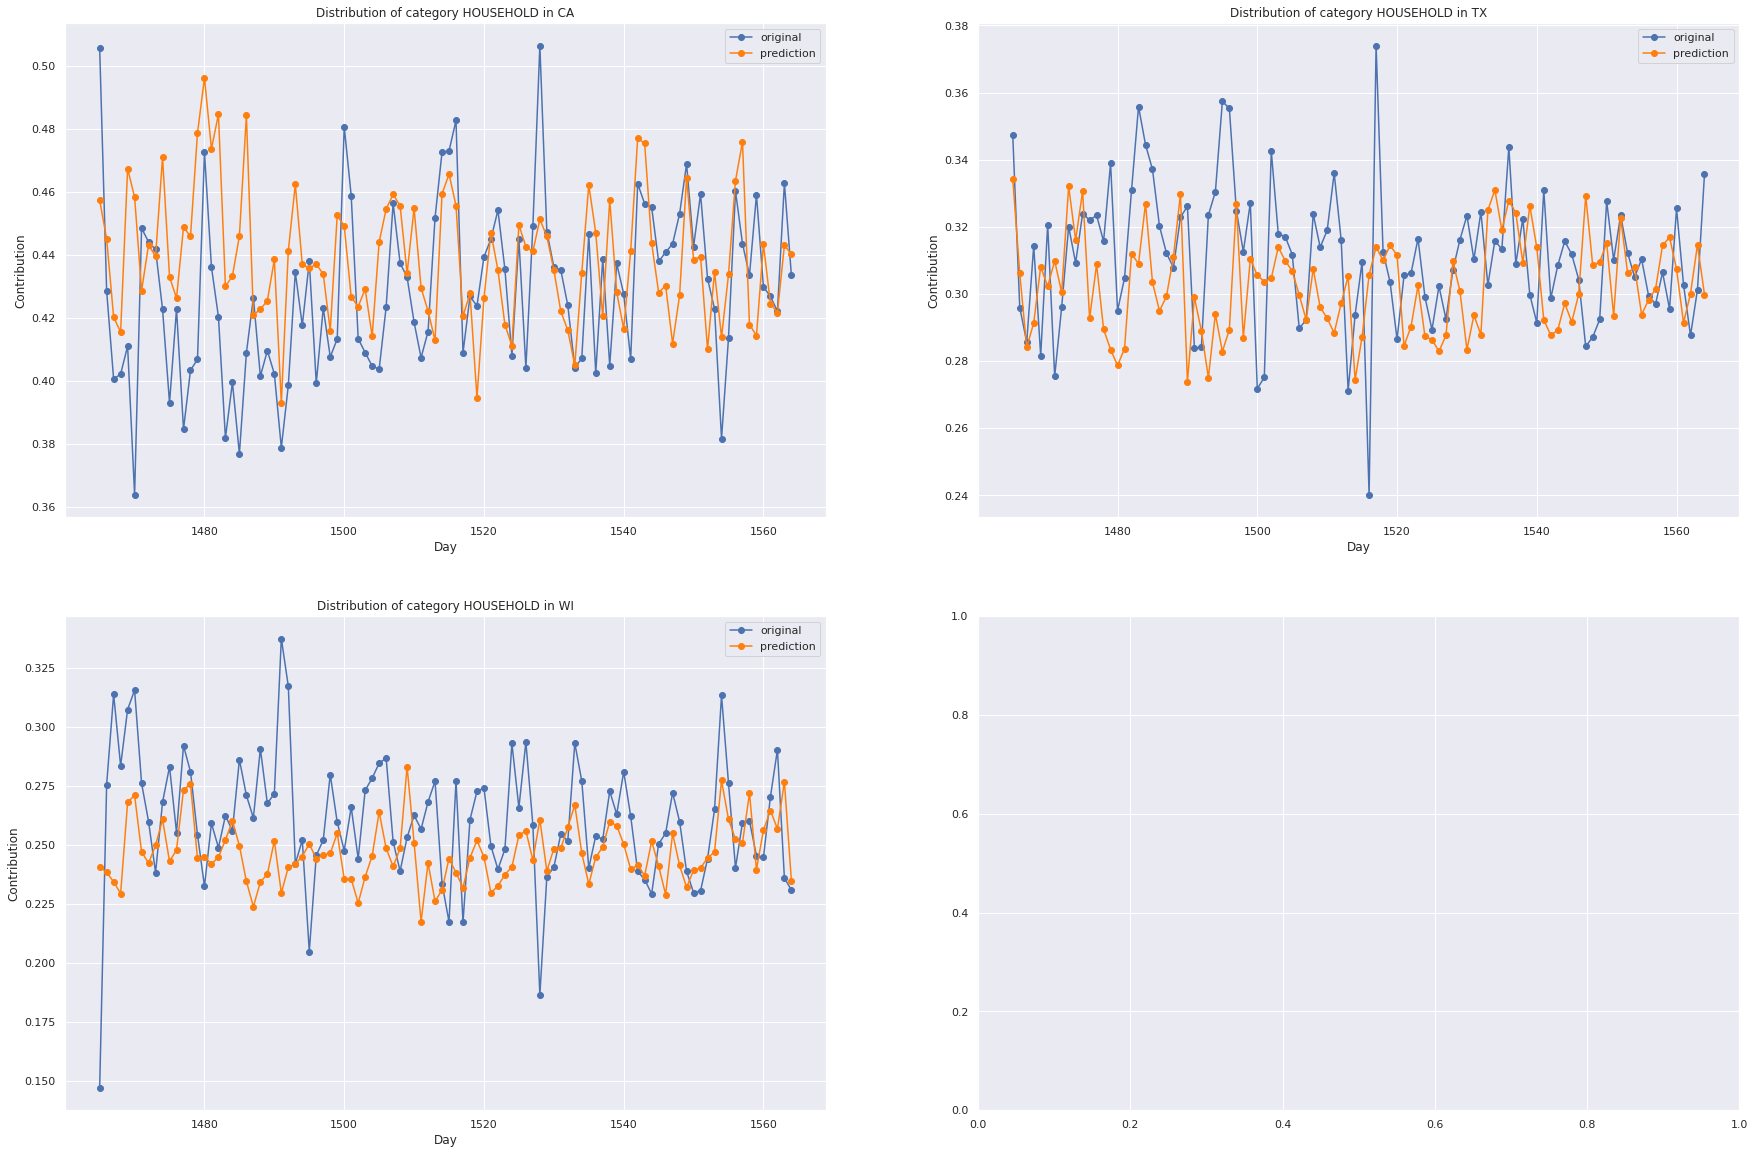

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(30,20))

graph_start = 700
graph_end = 800

plot_x = trainset['t'][graph_start:graph_end]

axs[0, 0].plot(plot_x, trainset['y1'][graph_start:graph_end], marker='o', label="original")
axs[0, 0].plot(trainset['t'][graph_start:graph_end], nn_keras_pred_train[:,0][graph_start:graph_end], 'tab:orange', marker='o', label="prediction")
axs[0, 0].set_title(f'Distribution of category {cat_id} in CA')
axs[0, 0].set(xlabel='Day', ylabel='Contribution')
axs[0, 0].legend(loc="upper right")

axs[0, 1].plot(plot_x, trainset['y2'][graph_start:graph_end], marker='o', label="original")
axs[0, 1].plot(plot_x, nn_keras_pred_train[:,1][graph_start:graph_end], 'tab:orange', marker='o', label="prediction")
axs[0, 1].set_title(f'Distribution of category {cat_id} in TX' )
axs[0, 1].set(xlabel='Day', ylabel='Contribution')
axs[0, 1].legend(loc="upper right")

axs[1, 0].plot(plot_x, trainset['y3'][graph_start:graph_end], marker='o', label="original")
axs[1, 0].plot(plot_x, nn_keras_pred_train[:,2][graph_start:graph_end], 'tab:orange', marker='o', label="prediction")
axs[1, 0].set_title(f'Distribution of category {cat_id} in WI')
axs[1, 0].set(xlabel='Day', ylabel='Contribution')
axs[1, 0].legend(loc="upper right")



##Visualizing accuracy on Testset

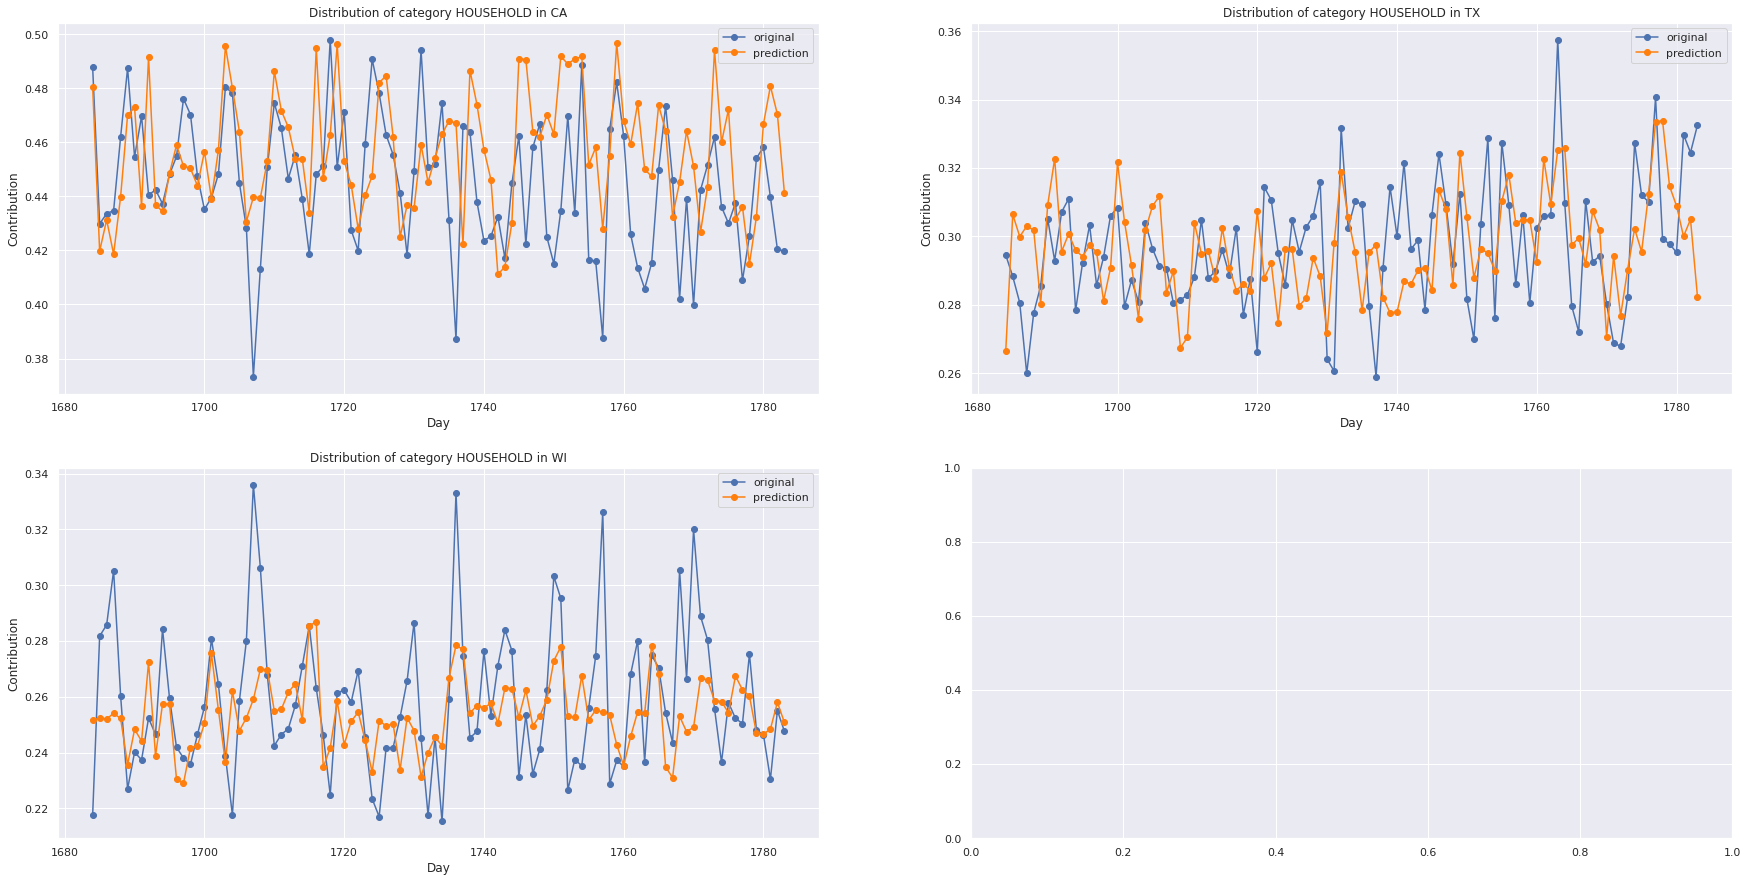

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(30,15))

graph_start = 0
graph_end = 100

plot_x = testset['t'][graph_start:graph_end]
plot_y = testset['y1'][graph_start:graph_end]

axs[0, 0].plot(plot_x, testset['y1'][graph_start:graph_end], marker='o', label="original")
axs[0, 0].plot(testset['t'][graph_start:graph_end], nn_keras_pred[:,0][graph_start:graph_end], 'tab:orange', marker='o', label="prediction")
axs[0, 0].set_title(f'Distribution of category {cat_id} in CA')
axs[0, 0].set(xlabel='Day', ylabel='Contribution')
axs[0, 0].legend(loc="upper right")

axs[0, 1].plot(plot_x, testset['y2'][graph_start:graph_end], marker='o', label="original")
axs[0, 1].plot(plot_x, nn_keras_pred[:,1][graph_start:graph_end], 'tab:orange', marker='o', label="prediction")
axs[0, 1].set_title(f'Distribution of category {cat_id} in TX')
axs[0, 1].set(xlabel='Day', ylabel='Contribution')
axs[0, 1].legend(loc="upper right")

axs[1, 0].plot(plot_x, testset['y3'][graph_start:graph_end], marker='o', label="original")
axs[1, 0].plot(plot_x, nn_keras_pred[:,2][graph_start:graph_end], 'tab:orange', marker='o', label="prediction")
axs[1, 0].set_title(f'Distribution of category {cat_id} in WI')
axs[1, 0].set(xlabel='Day', ylabel='Contribution')
axs[1, 0].legend(loc="upper right")